In [1]:
import os
import numpy as np
import cv2
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import graycomatrix, graycoprops, hog
from skimage.color import rgb2gray
import time
from sklearn.decomposition import PCA
import time
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import joblib

In [2]:
def extract_histogram(img, bins=(8, 8, 8)):
    # Ekstrak histogram warna RGB dari gambar
    hist = cv2.calcHist([img], [0, 1, 2], None, bins,
                        [0, 256, 0, 256, 0, 256])
    # Normalisasi histogram agar nilai antara 0-1
    cv2.normalize(hist, hist)
    # Kembalikan histogram sebagai array 1D
    return hist.flatten()

In [3]:
def extract_glcm(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    glcm = graycomatrix(gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    features = []
    for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']:
        features.append(graycoprops(glcm, prop)[0, 0])
    return np.array(features)

In [4]:
# Path ke dataset kamu
base_dir = "C:\\Projek GIthub\\KlasifikasiJamur\\Dataset6"

# Daftar nama folder / kelas
classes = ['Beracun', 'Tidak Beracun']

# List untuk data dan label
data = []
labels = []
combined_features = []
class_counts = {}

# Loop semua folder dan gambar dengan simple progress tracking
start_time = time.time()
print("Loading and extracting features from images...")

for label in classes:
    folder_path = os.path.join(base_dir, label)
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    original_count = len(image_files)
    class_counts[label] = original_count
    print(f"Found {original_count} images in class '{label}'")
    
    # Limit the number of images per class for faster training
    max_images_per_class = 1000  # Adjust this number as needed
    if len(image_files) > max_images_per_class:
        import random
        random.seed(42)  # For reproducibility
        image_files = random.sample(image_files, max_images_per_class)
        print(f"Limiting {label} class to {max_images_per_class} images")
    
    print(f"Processing {label} images...")
    
    for i, img_name in enumerate(image_files):
        if i % 100 == 0:  # Show progress every 100 images
            print(f"  Progress: {i}/{len(image_files)} images processed")
            
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, (128, 128))

        # Extract features
        hist = extract_histogram(img)
        glcm = extract_glcm(img)
     
        features = np.hstack([hist, glcm])
        combined_features.append(features)
        labels.append(label)
    
    print(f"Completed processing {len(image_files)} images for class '{label}'")

# Array final
le = LabelEncoder()
data = np.array(combined_features)
labels = np.array(labels)
labels_encoded = le.fit_transform(labels)

# Display dataset information

# Normalize features for better performance
print("\nNormalizing features...")
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
print("Feature normalization completed.")

print(f"\nFinal dataset shape: {data_scaled.shape}")

Loading and extracting features from images...
Found 1056 images in class 'Beracun'
Limiting Beracun class to 1000 images
Processing Beracun images...
  Progress: 0/1000 images processed
  Progress: 100/1000 images processed
  Progress: 200/1000 images processed
  Progress: 300/1000 images processed
  Progress: 400/1000 images processed
  Progress: 500/1000 images processed
  Progress: 600/1000 images processed
  Progress: 700/1000 images processed
  Progress: 800/1000 images processed
  Progress: 900/1000 images processed
Completed processing 1000 images for class 'Beracun'
Found 1200 images in class 'Tidak Beracun'
Limiting Tidak Beracun class to 1000 images
Processing Tidak Beracun images...
  Progress: 0/1000 images processed
  Progress: 100/1000 images processed
  Progress: 200/1000 images processed
  Progress: 300/1000 images processed
  Progress: 400/1000 images processed
  Progress: 500/1000 images processed
  Progress: 600/1000 images processed
  Progress: 700/1000 images proc

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data_scaled, labels_encoded, 
                                                    test_size=0.2, random_state=42, stratify=labels_encoded)

print(f"Training set: {len(X_train)}")
print(f"Testing set: {len(X_test)}")

Training set: 1600
Testing set: 400


In [6]:
print("\n🔍 Performing full hyperparameter tuning with GridSearchCV...")
start_time = time.time()

# Parameter grid
param_grid = [
    {
        'kernel': ['rbf'],
        'C': [1],
        'gamma': ['scale']
    }
]

# Buat objek GridSearchCV
grid_search = GridSearchCV(
    estimator=svm.SVC(probability=True),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,  # Tidak pakai verbose bawaan, kita cetak manual nanti
    return_train_score=True
)

# Latih semua kombinasi parameter
grid_search.fit(X_train, y_train)

# Ambil model dan parameter terbaik
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print(f"\n✅ Grid search selesai dalam {time.time() - start_time:.2f} detik")
print(f"🏆 Parameter terbaik: {best_params}")
print(f"🎯 Akurasi cross-validation terbaik: {grid_search.best_score_:.4f}")

# Simpan model terbaik
joblib.dump(best_model, 'best_mushroom_classifier.joblib')
print("💾 Model terbaik disimpan di 'best_mushroom_classifier.joblib'")




🔍 Performing full hyperparameter tuning with GridSearchCV...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

✅ Grid search selesai dalam 13.47 detik
🏆 Parameter terbaik: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
🎯 Akurasi cross-validation terbaik: 0.6787
💾 Model terbaik disimpan di 'best_mushroom_classifier.joblib'



Test Accuracy: 69.00%

Classification Report:
               precision    recall  f1-score   support

      Beracun       0.66      0.79      0.72       200
Tidak Beracun       0.74      0.59      0.66       200

     accuracy                           0.69       400
    macro avg       0.70      0.69      0.69       400
 weighted avg       0.70      0.69      0.69       400



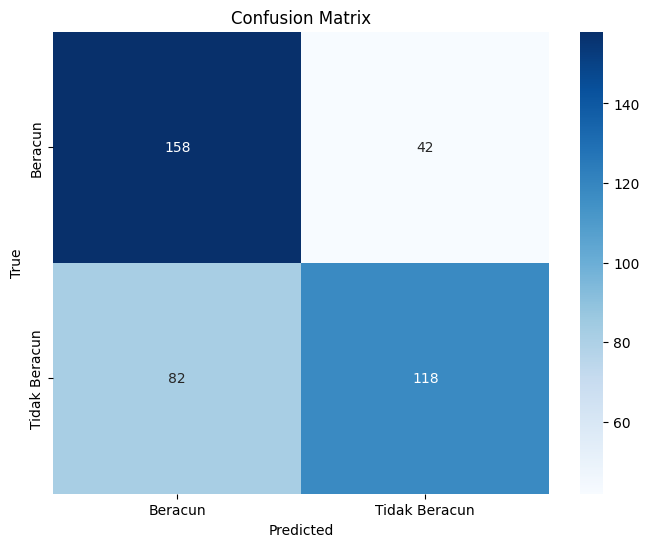

In [7]:
# Evaluate the best model
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

# Calculate accuracy
acc = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {acc*100:.2f}%")

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

